### assign GPU(s) - using 2 gpus so training happening on both in parallel

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [2]:
!pip install pandas --proxy http.proxy.fmr.com:8000 #-t --target "/mnt/home/packages/"
#!pip install editdistance --proxy http.proxy.fmr.com:8000 #-t --target "/mnt/home/packages/"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


### import libraries and packages

In [3]:
import pandas as pd
import sklearn
import os
import re
import sys
import string
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
sys.path.append('/mnt/home/packages/nltk_data/')
%matplotlib inline

import os
import argparse
import logging
import glob
import pandas as pd
import sklearn
import re # important
import sys 
import string 
import logging 
import numpy as np
import nltk # important
nltk.data.path.append("/mnt/home/packages/nltk_data/")

sys.path.append("/home/jovyan/.local/lib/python3.6/site-packages/")

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
  # important  -- okay to replace with large version
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report #evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.sparse import coo_matrix, hstack # matrix ---- replacable

import warnings
warnings.filterwarnings("ignore")

# import spell checker class - Alex -- to be replaced my javascript
#import spell
#from spell import SpellingAutocorrecter
sys.path.append('/mnt/home/packages')
#import spacy
 #import spacy and english module -- important
#nlp = spacy.load("en_core_web_sm")

# custom functions

#sc = SpellingAutocorrecter()
lemmatizer = nltk.stem.WordNetLemmatizer()

# utterance cleaning  function
def clean_text(text):
        text=str(text) # convert to string object   
        text = text.lower() # lowercase text

        #regex clean operations
        text = re.sub("[\(\[].*?[\)\]]", "", text) # remove [] & () brackets
        text = re.sub("[/(){}\[\]\|@,;]","", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
        text = re.sub("[^0-9a-z #+_]","", text) # delete symbols which are in numbers from text

         # in-house finanical spell checker 
        #text=" ".join(sc.correction(sc.tokenize(text))) ## spell check

        #lemmatization
        text=" ".join([lemmatizer.lemmatize(w) for w in text.split(" ")]) ##lemmatize

        return text  # return cleaned text


/home/jovyan/.local/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### read raw text files- change ur paths here

In [30]:
train=pd.read_csv('/mnt/home/VA-Data-Repo-master/sec_classifier2/data/NES_Export_Active_Intents_Only.csv')[['Sentence', 'Intent']]
#train.columns=['Sentence', 'Intent']
test=pd.read_csv('/mnt/home/VA-Data-Repo-master/sec_classifier2/data/TruthFileV2.csv')[['test sentence', 'expected intent']]
print(test.columns)
test.columns=train.columns

train=train[~train['Intent'].isin(['SENTENCE_FRAGMENTS',\
                                            'INCOMPREHENSION','NO_INTENT','OUT_OF_SCOPE','YES','NO'])]
train=train[~train.Intent.str.startswith('_')]
train=train[~train.Intent.str.contains('SOCIAL')]

#test=test[test.Intent.isin(train.Intent.unique())]
#train=train[train.Intent.isin(test.Intent.unique())]
train['flag']='train'
test['flag']='test'

all=pd.concat([train,test],ignore_index=True,axis=0,sort=False)

all=all[all.Sentence.notnull()]
#all['Sentence']=all.Sentence.astype(str)
all=all[~all['Intent'].isin(['SENTENCE_FRAGMENTS','INCOMPREHENSION','NO_INTENT','OUT_OF_SCOPE','YES','NO'])]
all=all[~all.Intent.str.contains('SOCIAL')]
all=all[~all.Intent.str.startswith('_')]
all['word_len']=all.Sentence.str.split(" ").map(len)
all=all[all.word_len>1]
all=all.groupby('Intent').filter(lambda x: len(x) >=4 )
all['sent']=all.Sentence.apply(clean_text)

from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
X_train, X_test, y_train, y_test = train_test_split(all.Sentence, all.Intent, stratify=all.Intent,
                                                            random_state=2018, test_size=0.22)  
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
print(train.shape)
print(test.shape)
print(train.Intent.nunique())
print(test.Intent.nunique())


Index(['test sentence', 'expected intent'], dtype='object')
(35236, 2)
(9939, 2)
424
424


### my text cleaning function - not needed for running BERT

### import package -  huggingface transformers and Encode Y variable to  number for classiification

In [31]:
#!pip install transformers
import torch
from transformers import *
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder().fit(train.Intent)
print(train.Intent.nunique())
print(test.Intent.nunique())

424
424


In [32]:

brackets_re = re.compile(r"[(\[].*?[)\]]")
replace_by_space_re = re.compile(r"[{}|@,;]")
non_alphanum_re = re.compile(r"[^0-9a-z#+_]")

def clean_text(text, spell_check=False):
        text = str(text).lower()  # lowercase text
        # regex clean operations
        text = re.sub(brackets_re, "", text)  # remove [] & () brackets
        text = re.sub(replace_by_space_re, " ", text)  # replace REPLACE_BY_SPACE_RE symbols by space in text
        text = re.sub(non_alphanum_re, " ", text)  # delete symbols which are not alphanumeric numbers from text
#         #text = re.sub(r"\s{2,}", " ", text)
#         # in-house financial spell checker
# #         if spell_check:
# #             text = " ".join(sc.correction(sc.tokenize(text,pos="v")))
#         #lemmatization
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split(" ")])
        return text  # return cleaned text

train['word_len']=train.Sentence.str.split(" ").map(len)
train=train[(train.word_len>=2) & (train.word_len<=30)]
train.drop(columns=['word_len'],inplace=True)
train['sent']=train.Sentence.apply(clean_text)

### Load BERT tokenizer - load ur cached model (or from aws if u have internet connection)

In [33]:
from transformers import BertTokenizer

sentences = train.sent.values
labels = le.transform(train.Intent)

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('/mnt/home/NLP/NLP_models/bert_model/', do_lower_case=True)
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading BERT tokenizer...
 Original:  can you help estimate day trade call   am i made any mistake   how to fix  
Tokenized:  ['can', 'you', 'help', 'estimate', 'day', 'trade', 'call', 'am', 'i', 'made', 'any', 'mistake', 'how', 'to', 'fix']
Token IDs:  [2064, 2017, 2393, 10197, 2154, 3119, 2655, 2572, 1045, 2081, 2151, 6707, 2129, 2000, 8081]


### Run tokenizer on your text column

In [34]:
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  can you help estimate day trade call   am i made any mistake   how to fix  
Token IDs: [101, 2064, 2017, 2393, 10197, 2154, 3119, 2655, 2572, 1045, 2081, 2151, 6707, 2129, 2000, 8081, 102]


### limit the text to max length -- change max len value according to your data, 
### padding the input for 512 - dont change padding - this is required


In [35]:
from scipy import stats
print('sentence length: ', np.quantile([len(sen) for sen in input_ids],np.arange(0.99,1,0.001)))
print('Max sentence length: ', max([len(sen) for sen in input_ids]))
#print('Mean sentence length: ', np.mean([len(sen) for sen in input_ids]))
MAX_LEN=32
len(input_ids[1])
input_ids_pad=[]
for arr in input_ids:
    arr=arr[:32]
    input_ids_pad.append(np.pad(arr, (0,MAX_LEN-len(arr)), mode='constant'))

    

sentence length:  [27.    27.    27.    27.    28.    28.    28.    28.352 29.    30.
 39.   ]
Max sentence length:  39


In [36]:
len(input_ids_pad[1])

32

### add attention masks for actual input value as 1 and 0 for padding - this is required

In [37]:
attention_masks = []

# For each sentence...
for sent in input_ids_pad:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

### create a dev set (10%) to test model and tune hyper-parameters -- change ur % if needed
### final model will be evaluated on unseen test set

In [38]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_pad, labels, 
                                                            random_state=2018, test_size=0.02)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.02)

### convert python objects to torch tensors

In [39]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### make batches and dataloader - you change batch size if u want
### batch size > 128 gives out of memory for 2 gpu

In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### import BertForSequenceClassification -- change ur num of classes as per your data
### i am doing 483 class text classification

In [41]:
len(np.unique(labels))

424

In [57]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn as nn
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "/mnt/home/NLP/NLP_models/bert_model/", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(np.unique(labels)), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model = nn.DataParallel(model)
# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at /mnt/home/NLP/NLP_models/bert_model/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the 

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

###  hyper paramters - learning rate, epochs and lr scheduler  for finetuning - change if u need to

In [59]:
params = list(model.named_parameters())
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 0.00005, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 18

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### my accuracy function -- dont change

In [60]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## parallel Training on  2 GPUs

In [61]:
#model=torch.load('/mnt/home/VA-Data-Repo-master/cust_VA/saved_models/bert-model-76.7%acc')
#model=nn.DataParallel(model)
#model.to(device)

### actual model training step - run this as is , no changes needed

In [62]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.mean().item()
        # Perform a backward pass to calculate the gradients.
        loss.mean().backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")


======== Epoch 1 / 18 ========
Training...
  Batch   100  of  1,079.    Elapsed: 0:00:13.
  Batch   200  of  1,079.    Elapsed: 0:00:26.
  Batch   300  of  1,079.    Elapsed: 0:00:39.
  Batch   400  of  1,079.    Elapsed: 0:00:52.
  Batch   500  of  1,079.    Elapsed: 0:01:05.
  Batch   600  of  1,079.    Elapsed: 0:01:18.
  Batch   700  of  1,079.    Elapsed: 0:01:31.
  Batch   800  of  1,079.    Elapsed: 0:01:44.
  Batch   900  of  1,079.    Elapsed: 0:01:59.
  Batch 1,000  of  1,079.    Elapsed: 0:02:12.

  Average training loss: 3.36
  Training epcoh took: 0:02:22

Running Validation...
  Accuracy: 0.6386
  Validation took: 0:00:01

======== Epoch 2 / 18 ========
Training...
  Batch   100  of  1,079.    Elapsed: 0:00:13.
  Batch   200  of  1,079.    Elapsed: 0:00:26.
  Batch   300  of  1,079.    Elapsed: 0:00:39.
  Batch   400  of  1,079.    Elapsed: 0:00:53.
  Batch   500  of  1,079.    Elapsed: 0:01:07.
  Batch   600  of  1,079.    Elapsed: 0:01:20.
  Batch   700  of  1,079.    

  Batch 1,000  of  1,079.    Elapsed: 0:02:15.

  Average training loss: 0.02
  Training epcoh took: 0:02:25

Running Validation...
  Accuracy: 0.8030
  Validation took: 0:00:01

======== Epoch 14 / 18 ========
Training...
  Batch   100  of  1,079.    Elapsed: 0:00:13.
  Batch   200  of  1,079.    Elapsed: 0:00:27.
  Batch   300  of  1,079.    Elapsed: 0:00:41.
  Batch   400  of  1,079.    Elapsed: 0:00:54.
  Batch   500  of  1,079.    Elapsed: 0:01:08.
  Batch   600  of  1,079.    Elapsed: 0:01:21.
  Batch   700  of  1,079.    Elapsed: 0:01:34.
  Batch   800  of  1,079.    Elapsed: 0:01:47.
  Batch   900  of  1,079.    Elapsed: 0:02:00.
  Batch 1,000  of  1,079.    Elapsed: 0:02:13.

  Average training loss: 0.01
  Training epcoh took: 0:02:23

Running Validation...
  Accuracy: 0.8071
  Validation took: 0:00:01

======== Epoch 15 / 18 ========
Training...
  Batch   100  of  1,079.    Elapsed: 0:00:13.
  Batch   200  of  1,079.    Elapsed: 0:00:25.
  Batch   300  of  1,079.    Elapsed:

KeyboardInterrupt: 

### plot loss values

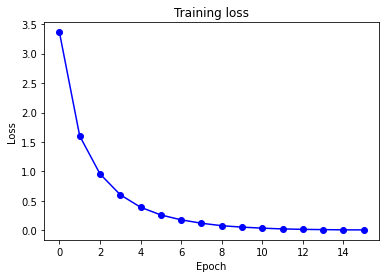

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns

# Use plot styling from seaborn.
#sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
#plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [64]:
loss_values

[3.362189026758337,
 1.602026161769676,
 0.9578676270709422,
 0.6039362874182427,
 0.3921927194058398,
 0.2614820152659235,
 0.17854712566531733,
 0.12094072895374863,
 0.07895254682787488,
 0.05480360203147266,
 0.037434653676804625,
 0.024351577912358025,
 0.016966168558962155,
 0.012707279637745953,
 0.008811663901839023,
 0.007537094197746114]

In [88]:
#model=torch.load('/mnt/home/VA-Data-Repo-master/cust_VA/saved_models/bert_80%acc')

## Inferenece on unseen test set - 
### part 1 - prep data

In [65]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("/mnt/home/VA-Data-Repo-master/truth_stratified.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))
test['word_len']=test.Sentence.str.split(" ").map(len)
test=test[(test.word_len>=2) & (test.word_len<=30)]
test.drop(columns=['word_len'],inplace=True)
test['sent']=test.Sentence.apply(clean_text)
# Create sentence and label lists
sentences = test.sent.values
labels = le.transform(test.Intent.values)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
print('Max sentence length: ', max([len(sen) for sen in input_ids]))
MAX_LEN=32
#len(input_ids[1])
input_ids_pad=[]
for arr in input_ids:
    arr=arr[:32]
    input_ids_pad.append(np.pad(arr, (0,MAX_LEN-len(arr)), mode='constant'))
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_pad:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids_pad)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 9,932

Max sentence length:  34


### inference part 2 - run model predictions

In [66]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 9,932 test sentences...
    DONE.


### part 3 : calculate accuracy on test set

In [67]:
# Combine the predictions for each batch into a single list of 0s and 1s.
from sklearn.metrics import accuracy_score
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

#print(matthews_corrcoef(flat_true_labels, flat_predictions))
print(round(accuracy_score(flat_predictions, flat_true_labels),4)*100)

80.77


In [29]:
labels=pd.Series(le.inverse_transform(flat_predictions))
len(labels)
test['len']=test.Sentence.str.split(" ").str.len()
test.drop('sent',axis=1,inplace=True)
test1=pd.concat([test,labels],axis=1,ignore_index=True)
test1.columns=['sentence','truelabel','len','predlabel']
#test1.to_csv()

KeyError: "['sent'] not found in axis"

### TOP 3 Intents

In [80]:
flat_predictions = [item for sublist in predictions for item in sublist]
print(len(flat_predictions))
best_n = np.argsort(flat_predictions, axis=1)[:,-3:]
arr=[]
for item in best_n:
    arr.append(le.inverse_transform(item))
arr=pd.DataFrame(arr)
print(arr.shape)
print(test.shape)
test1=pd.concat([test[['Sentence','Intent','word_len']],arr],axis=1)
print(test.shape)
test1.columns=['Sentence','truelabel','len','predlabel3','predlabel2','predlabel1']
test1.columns

10612
(10612, 3)
(10612, 7)
(10612, 7)


Index(['Sentence', 'truelabel', 'len', 'predlabel3', 'predlabel2',
       'predlabel1'],
      dtype='object')

In [81]:
sum( (test1.truelabel==test1.predlabel1))

242

In [82]:
torch.save(model, '/mnt/home/VA-Data-Repo-master/cust_VA/saved_models/chatbert-77.43%acc')

In [ ]:
#test1.to_csv('/mnt/home/VA-Data-Repo-master/cust_VA/model_3_intents.csv')